In [ ]:
from google.colab import drive
from os import walk
import os

drive.mount("/content/drive", force_remount=True)

path = '/content/drive/My Drive/Fresh_and_Stale_medium'

Mounted at /content/drive


In [ ]:
from torchvision import datasets, transforms
import numpy as np
from torch.utils.data.sampler import WeightedRandomSampler
from torchvision.datasets import ImageFolder

#Defining tranforms for dataset
transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

dataset = ImageFolder(path, transform=transform)

In [ ]:
#Split into training, testing and validation set
from torch.utils.data import random_split

train_size = int(0.8 * len(dataset))

test_size = int(0.1 * len(dataset))

val_size = len(dataset) - train_size - test_size

train_dataset, test_dataset, val_dataset = random_split(dataset, [train_size, test_size, val_size])

In [ ]:
import torch
train_dataset.targets = torch.tensor([train_dataset.dataset.targets[i] for i in train_dataset.indices]).numpy().tolist()
train_dataset.label = torch.tensor([train_dataset.dataset.samples[i][1] for i in train_dataset.indices]).numpy().tolist()

In [ ]:
train_dataloader_imbal = torch.utils.data.DataLoader(train_dataset, batch_size = 64, num_workers=2)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size = 64, num_workers=2)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size = 64, num_workers=2)

In [ ]:
from torchvision import models
import torch.nn as nn
num_classes = 6

model_resnet_imbal=models.resnet18(pretrained=False)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

loss_fn=nn.CrossEntropyLoss()
optimizer_resnet_imbal=torch.optim.Adam(model_resnet_imbal.parameters(),lr=0.01)

In [ ]:
if torch.cuda.is_available():
    device = torch.device('cuda:0')
    print("Using GPU")
else:
    device = torch.device('cpu')
    print("Using CPU")

Using GPU


In [ ]:
from tqdm.notebook import tqdm_notebook

def train(model,optimizer,num_epochs,train_dl,valid_dl,train_data_percent,model_name):
    model.to(device)
    max_acc=0.0
    torch.save(model.state_dict(),f"best_weights_of_{model_name}.pt")
    loss_hist_train=[0]*num_epochs
    accuracy_hist_train=[0]*num_epochs
    loss_hist_valid=[0]*num_epochs
    accuracy_hist_valid=[0]*num_epochs
    no_of_batches_to_train=int(round(len(train_dl)*train_data_percent))
    for epoch in tqdm_notebook(range(num_epochs),desc="Number of Epochs Completed"):
        model.train()
        count=0
        for x_batch,y_batch in tqdm_notebook(train_dl,desc="Number of Training Batches Completed"):
            if train_data_percent!=1 and count>no_of_batches_to_train:
                break
            count+=1
            x_batch,y_batch=x_batch.to(device),y_batch.to(device)
            pred=model(x_batch)
            loss=loss_fn(pred,y_batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            loss_hist_train[epoch]+=loss.item()*y_batch.size(0)
            is_correct=(torch.argmax(pred,dim=1)==y_batch).float()
            accuracy_hist_train[epoch]+=is_correct.sum()
        loss_hist_train[epoch]/=len(train_dl.dataset)
        accuracy_hist_train[epoch]/=len(train_dl.dataset)

        model.eval()
        with torch.no_grad():
            for x_batch,y_batch in tqdm_notebook(valid_dl,desc="Number of Validation Batches Completed"):
                x_batch,y_batch=x_batch.to(device),y_batch.to(device)
                pred=model(x_batch)
                loss=loss_fn(pred,y_batch)
                loss_hist_valid[epoch]+=loss.item()*y_batch.size(0)
                is_correct=(torch.argmax(pred,dim=1)==y_batch).float()
                accuracy_hist_valid[epoch]+=is_correct.sum()
            loss_hist_valid[epoch]/=len(valid_dl.dataset)
            accuracy_hist_valid[epoch]/=len(valid_dl.dataset)
        if accuracy_hist_valid[epoch]>max_acc:
            max_acc=accuracy_hist_valid[epoch]
            torch.save(model.state_dict(),f"best_weights_of_{model_name}.pt")
        print(f'Epoch {epoch+1} accuracy: '
               f'{accuracy_hist_train[epoch]:.4f} val_accuracy: '
               f'{accuracy_hist_valid[epoch]:.4f}')
    return loss_hist_train, loss_hist_valid, \
            accuracy_hist_train, accuracy_hist_valid



In [ ]:
num_epochs=10
hist_resnet_imbal=train(model_resnet_imbal,optimizer_resnet_imbal,num_epochs,train_dataloader_imbal,val_dataloader,0.2,"model_resnet_imbal")

Number of Epochs Completed:   0%|          | 0/10 [00:00<?, ?it/s]

Number of Training Batches Completed:   0%|          | 0/88 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Number of Validation Batches Completed:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 1 accuracy: 0.1117 val_accuracy: 0.2723


Number of Training Batches Completed:   0%|          | 0/88 [00:00<?, ?it/s]

Number of Validation Batches Completed:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 2 accuracy: 0.1710 val_accuracy: 0.7262


Number of Training Batches Completed:   0%|          | 0/88 [00:00<?, ?it/s]

Number of Validation Batches Completed:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 3 accuracy: 0.1851 val_accuracy: 0.8596


Number of Training Batches Completed:   0%|          | 0/88 [00:00<?, ?it/s]

Number of Validation Batches Completed:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 4 accuracy: 0.1915 val_accuracy: 0.8809


Number of Training Batches Completed:   0%|          | 0/88 [00:00<?, ?it/s]

Number of Validation Batches Completed:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 5 accuracy: 0.1917 val_accuracy: 0.7532


Number of Training Batches Completed:   0%|          | 0/88 [00:00<?, ?it/s]

Number of Validation Batches Completed:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 6 accuracy: 0.1892 val_accuracy: 0.9461


Number of Training Batches Completed:   0%|          | 0/88 [00:00<?, ?it/s]

Number of Validation Batches Completed:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 7 accuracy: 0.1957 val_accuracy: 0.9007


Number of Training Batches Completed:   0%|          | 0/88 [00:00<?, ?it/s]

Number of Validation Batches Completed:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 8 accuracy: 0.1954 val_accuracy: 0.8496


Number of Training Batches Completed:   0%|          | 0/88 [00:00<?, ?it/s]

Number of Validation Batches Completed:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 9 accuracy: 0.1957 val_accuracy: 0.8965


Number of Training Batches Completed:   0%|          | 0/88 [00:00<?, ?it/s]

Number of Validation Batches Completed:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 10 accuracy: 0.1956 val_accuracy: 0.9021


In [ ]:
import torch
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

def test_model(model, dataloader):
    model.eval()
    y_true = []
    y_pred = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    return y_true, y_pred

In [ ]:
# Test the model
y_true, y_pred = test_model(model_resnet_imbal, test_dataloader)

# Calculate confusion matrix
conf_matrix_imbal = confusion_matrix(y_true, y_pred)
print(conf_matrix_imbal)

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


[[138  10   0   0   2   2]
 [  1 158   0   0   0   0]
 [  2  14  12   3   0   1]
 [  2   9   9  82   0   0]
 [  2   7   1   0 136   0]
 [  0   0   0   0   0 112]]


In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred, target_names =['fresh_apple', 'fresh_banana', 'fresh_bitter_gourd',
       'fresh_capsicum', 'fresh_orange', 'fresh_tomato'], digits=4))

                    precision    recall  f1-score   support

       fresh_apple     0.9517    0.9079    0.9293       152
      fresh_banana     0.7980    0.9937    0.8852       159
fresh_bitter_gourd     0.5455    0.3750    0.4444        32
    fresh_capsicum     0.9647    0.8039    0.8770       102
      fresh_orange     0.9855    0.9315    0.9577       146
      fresh_tomato     0.9739    1.0000    0.9868       112

          accuracy                         0.9075       703
         macro avg     0.8699    0.8353    0.8467       703
      weighted avg     0.9109    0.9075    0.9047       703



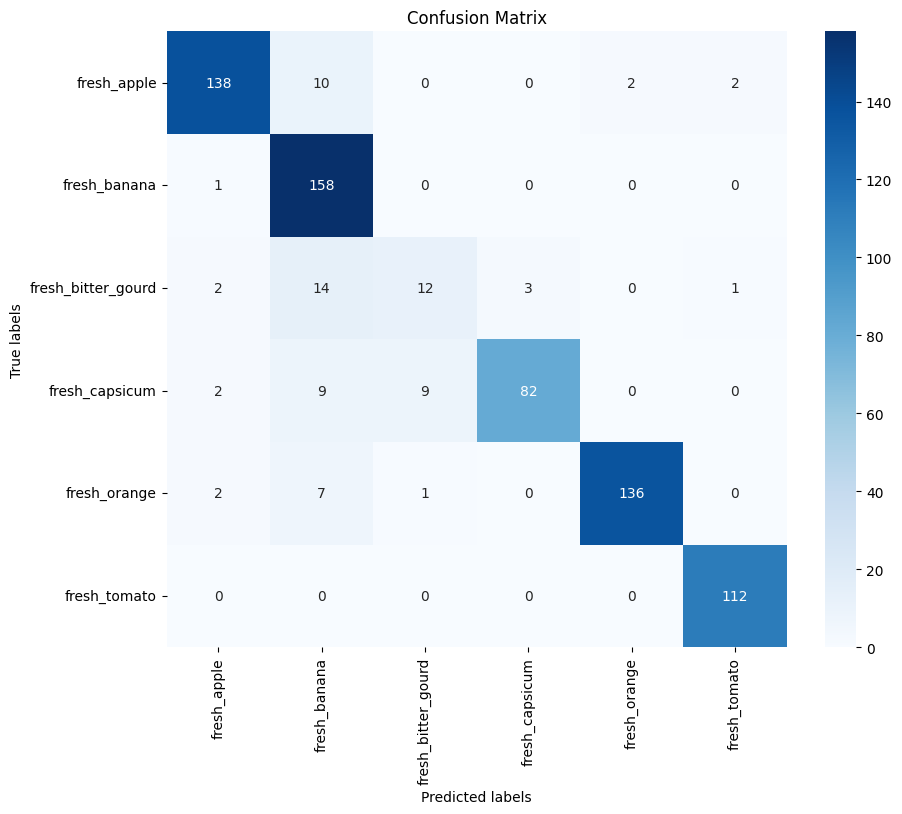

In [ ]:
# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix_imbal, annot=True, fmt="d", cmap="Blues", xticklabels=dataset.classes, yticklabels=dataset.classes)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
train_accuracies_imbal = []
test_accuracies_imbal = []
for i in range(len(hist_resnet_imbal[2])):
    if device.type == 'cuda':
      train_accuracies_imbal.append(hist_resnet_imbal[2][i].cpu().numpy().tolist())
      test_accuracies_imbal.append(hist_resnet_imbal[3][i].cpu().numpy().tolist())
    else:
      train_accuracies_imbal.append(hist_resnet_imbal[2][i].numpy().tolist())
      test_accuracies_imbal.append(hist_resnet_imbal[3][i].numpy().tolist())

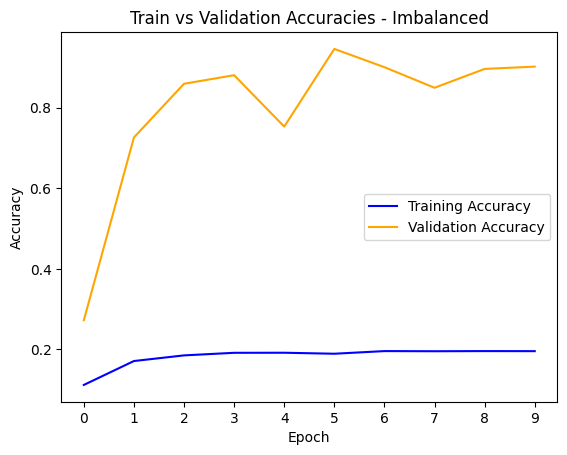

In [ ]:
sns.lineplot(x = range(10), y = train_accuracies_imbal, color = "blue", label = "Training Accuracy")
sns.lineplot(x = range(10), y = test_accuracies_imbal, color = "orange", label = "Validation Accuracy")
plt.title("Train vs Validation Accuracies - Imbalanced")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.xticks(range(0,10))
plt.yticks(label = range(0,1))
plt.legend()
plt.show()